# completo 

Valores faltantes por columna:
reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
instrumentType    0
dtype: int64
No se encontraron valores faltantes. Continuando con el preprocesamiento...

IQR: 390.0
Datos después de eliminar outliers: 9363 filas

Matriz de correlación:
                review_length   overall
review_length       1.000000 -0.052335
overall            -0.052335  1.000000


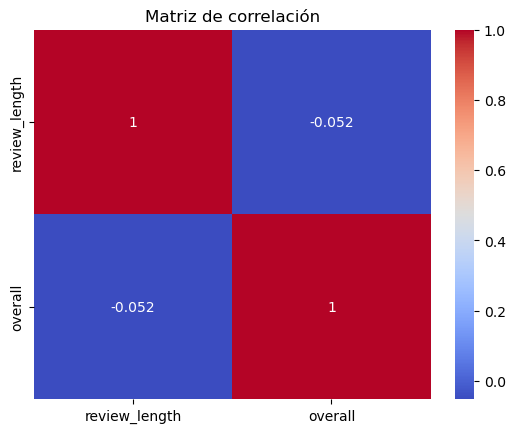

Varianza explicada por PCA (50 componentes): 0.17

F1-Score Promedio:
Random Forest: 0.57
SVM: 0.52
Red Neuronal: 0.56


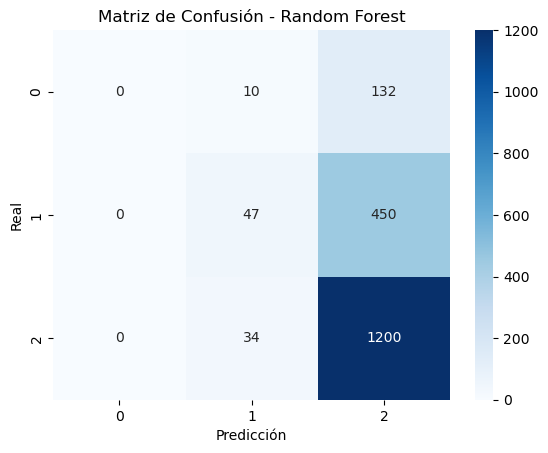

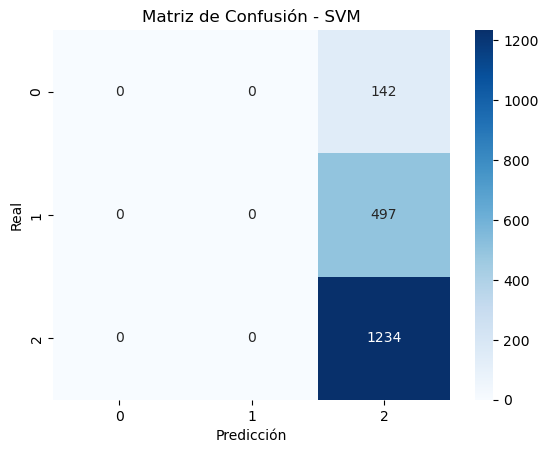

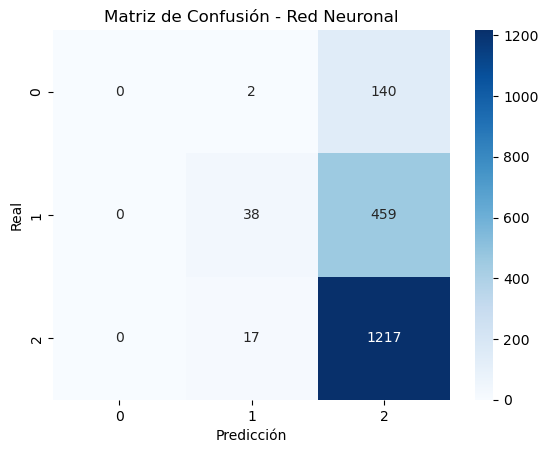

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar el dataset
valoraciones = pd.read_json('data/web_reviews.json')

# Buscar valores faltantes
missing_values = valoraciones.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

if missing_values.sum() == 0:
    print("No se encontraron valores faltantes. Continuando con el preprocesamiento...\n")

# Preprocesamiento
valoraciones['review_length'] = valoraciones['reviewText'].apply(len)

def map_to_sentiment(overall):
    if overall <= 2:
        return 'Negativo'
    elif overall <= 4:
        return 'Neutro'
    else:
        return 'Positivo'

valoraciones['sentiment'] = valoraciones['overall'].map(map_to_sentiment)

# Detección y tratamiento de outliers en 'review_length' utilizando el IQR
q1 = valoraciones['review_length'].quantile(0.25)
q3 = valoraciones['review_length'].quantile(0.75)
iqr = q3 - q1
print(f"IQR: {iqr}")

# Filtrar outliers
valoraciones = valoraciones[(valoraciones['review_length'] >= q1 - 1.5 * iqr) & 
                            (valoraciones['review_length'] <= q3 + 1.5 * iqr)]

print(f"Datos después de eliminar outliers: {valoraciones.shape[0]} filas\n")

# Análisis de correlación entre variables numéricas
correlation_matrix = valoraciones[['review_length', 'overall']].corr()
print("Matriz de correlación:\n", correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

# Vectorización del texto
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(valoraciones['reviewText'])

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=50)  # Seleccionar 50 componentes como ejemplo
X_text_pca = pca.fit_transform(X_text.toarray())
print(f"Varianza explicada por PCA (50 componentes): {np.sum(pca.explained_variance_ratio_):.2f}")

# Convertir X_features a matriz dispersa
X_features = valoraciones[['review_length']]
X_features_sparse = csr_matrix(X_features.values)

# Combinación de características
X_combined = hstack((X_text_pca, X_features_sparse))

y = valoraciones['sentiment']

# División de datos
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Modelo Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_combined, y_train)
y_pred_rf = model_rf.predict(X_test_combined)

# SVM
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# Red Neuronal
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp_model.fit(X_train_combined, y_train)
y_pred_mlp = mlp_model.predict(X_test_combined)

# Comparación de modelos
print("\nF1-Score Promedio:")
print(f"Random Forest: {f1_score(y_test, y_pred_rf, average='weighted'):.2f}")
print(f"SVM: {f1_score(y_test, y_pred_svm, average='weighted'):.2f}")
print(f"Red Neuronal: {f1_score(y_test, y_pred_mlp, average='weighted'):.2f}")

# Matrices de Confusión
for model_name, y_pred in zip(['Random Forest', 'SVM', 'Red Neuronal'], 
                              [y_pred_rf, y_pred_svm, y_pred_mlp]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


Valores nulos antes del tratamiento:
reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
instrumentType    0
dtype: int64
Valores nulos después del tratamiento:
reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
instrumentType    0
dtype: int64


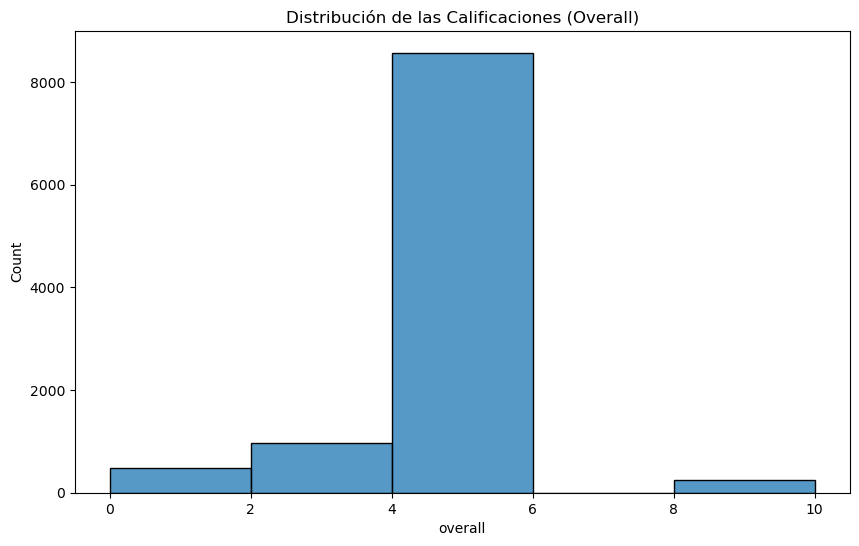

KeyError: "None of [Index(['review_length'], dtype='object')] are in the [columns]"

<Figure size 1000x600 with 0 Axes>

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import nltk

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Cargar datos
valoraciones = pd.read_json('data/web_reviews.json')

# Paso 1: Preprocesamiento de Datos
print("\nEstructura del dataset:")
print(valoraciones.info())

# Revisar valores faltantes
print("\nValores faltantes por columna:")
print(valoraciones.isnull().sum())

# Imputación de valores faltantes
valoraciones['reviewText'].fillna('Texto no disponible', inplace=True)
valoraciones['overall'].fillna(valoraciones['overall'].median(), inplace=True)

# Análisis de correlación
corr_matrix = valoraciones.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Tratamiento de outliers en 'overall' usando Z-score
valoraciones['z_score'] = zscore(valoraciones['overall'])
valoraciones = valoraciones[valoraciones['z_score'].abs() < 3]  # Filtrar valores atípicos

# Discretización de calificaciones (overall)
def map_to_sentiment(overall):
    if overall <= 2:
        return 'Negativo'
    elif overall == 3:
        return 'Neutro'
    else:
        return 'Positivo'

valoraciones['sentiment'] = valoraciones['overall'].map(map_to_sentiment)

# Estandarización de longitudes de reseñas
valoraciones['review_length'] = valoraciones['reviewText'].apply(len)
scaler = StandardScaler()
valoraciones['review_length_scaled'] = scaler.fit_transform(valoraciones[['review_length']])

# Paso 2: Análisis de Sentimientos con NLP
# Procesamiento de texto
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(tokens)

valoraciones['cleaned_review'] = valoraciones['reviewText'].apply(preprocess_text)

# Vectorización
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(valoraciones['cleaned_review'])

# Paso 3: Implementación de Modelos de Clasificación
X_features = valoraciones[['review_length_scaled']]
X_combined = scipy.sparse.hstack((X_text, X_features))
y = valoraciones['sentiment']

# División de datos
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(rf_model, rf_params, n_iter=10, cv=3, scoring='f1_weighted', verbose=2, random_state=42)
rf_random_search.fit(X_train_combined, y_train)
y_pred_rf = rf_random_search.best_estimator_.predict(X_test_combined)

# SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_combined, y_train)
y_pred_svm = svm_model.predict(X_test_combined)

# Red Neuronal
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp_model.fit(X_train_combined, y_train)
y_pred_mlp = mlp_model.predict(X_test_combined)

# Evaluación y comparación de modelos
print("\nComparación de Modelos:")
for model_name, y_pred in zip(['Random Forest', 'SVM', 'Red Neuronal'], [y_pred_rf, y_pred_svm, y_pred_mlp]):
    print(f"\nModelo: {model_name}")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1-Score (weighted): {f1:.2f}")


# Importación de librerías y Carga de datos

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import normaltest
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
valoraciones = pd.read_json('data/web_reviews.json')


# Exploración y Estadísticas Descriptivas

In [5]:
print("Primeras filas del dataset:")
print(valoraciones.head())

print("\nInformación del dataset:")
print(valoraciones.info())

print("\nEstadísticas descriptivas de la calificación 'overall':")
print(valoraciones['overall'].describe())

print("\nDistribución de calificaciones (overall):")
print(valoraciones['overall'].value_counts())

valoraciones['review_length'] = valoraciones['reviewText'].apply(len)
print("\nLongitud promedio de las reseñas:")
print(valoraciones['review_length'].mean())


Primeras filas del dataset:
       reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                      Rick Bennette "Rick Bennette    [1, 1]   
3                          RustyBill "Sunday Rocker    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...        5   
1  The product does exactly as it should and is q...        5   
2  The primary job of this device is to block the...        5   
3  Nice windscreen protects my MXL mic and preven...        5   
4  This pop filter is great. It looks and perform...     

# Visualización inicial

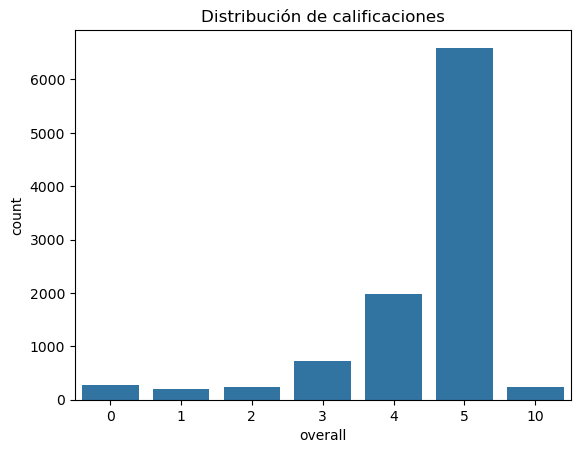

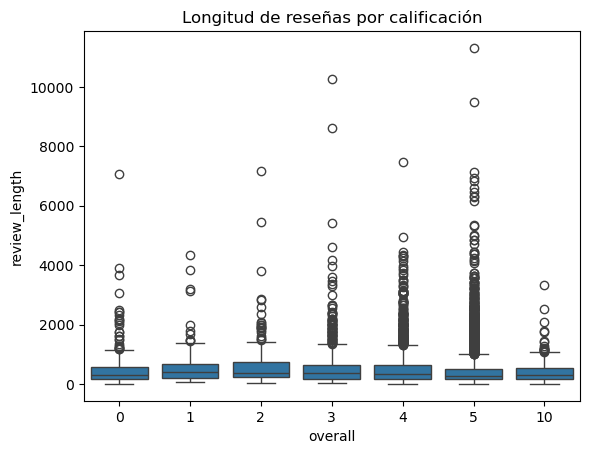

In [6]:
sns.countplot(x='overall', data=valoraciones)
plt.title('Distribución de calificaciones')
plt.show()

sns.boxplot(x='overall', y='review_length', data=valoraciones)
plt.title('Longitud de reseñas por calificación')
plt.show()


# Preprocesamiento de datos 

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(valoraciones['reviewText'])


# Mapeo clases sentimentales 

In [8]:
def map_to_sentiment(overall):
    if overall <= 2:
        return 'Negativo'
    elif overall <= 5:
        return 'Neutro'
    else:
        return 'Positivo'

valoraciones['sentiment'] = valoraciones['overall'].map(map_to_sentiment)


# Dvision de datos 

In [ ]:
X_features = valoraciones[['review_length']]
X_combined = scipy.sparse.hstack((X_text, X_features))
y = valoraciones['overall']

X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


# Entrenamiento Modelo Random Forest 

In [10]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_combined, y_train)


RandomForestClassifier(random_state=42)

# Evaluación del modelo


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        51
           3       0.33      0.01      0.01       131
           4       0.83      0.01      0.03       389
           5       0.65      1.00      0.79      1329
          10       0.00      0.00      0.00        54

    accuracy                           0.65      2053
   macro avg       0.26      0.15      0.12      2053
weighted avg       0.60      0.65      0.52      2053



c:\Users\trini\miniconda3\envs\TODO_py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\trini\miniconda3\envs\TODO_py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\trini\miniconda3\envs\TODO_py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

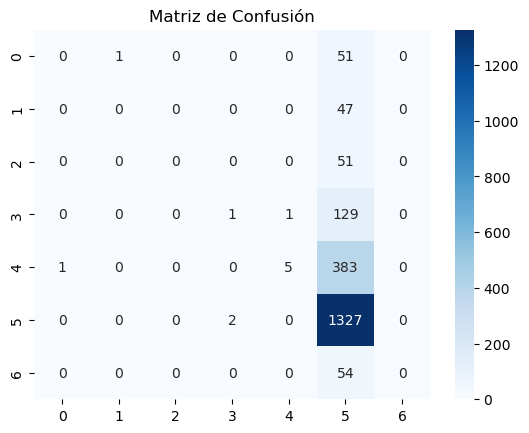

In [ ]:
y_pred_rf = model_rf.predict(X_test_combined)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.show()


# Optimización con RandomizedSearchCV

In [12]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    scoring='accuracy'
)
random_search.fit(X_train_combined, y_train)

best_model = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.8s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  10.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  10.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.8s
[CV] END max_dept

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

# Vectorización del texto
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(valoraciones['reviewText'])

# Agregar características adicionales, como review_length
X_features = valoraciones[['review_length']]

# Combinar características de texto y numéricas
X_combined = hstack((X_text, X_features))

# División de datos
y = valoraciones['sentiment']  # Usar el mapeo de 'overall' a 'sentiment'
X_train_combined, X_test_combined, y_train_mapped, y_test_mapped = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)


# SVM 



Reporte de clasificación para SVM:
              precision    recall  f1-score   support

    Negativo       0.26      0.33      0.29       150
      Neutro       0.92      0.91      0.91      1849
    Positivo       0.02      0.02      0.02        54

    accuracy                           0.84      2053
   macro avg       0.40      0.42      0.41      2053
weighted avg       0.85      0.84      0.84      2053



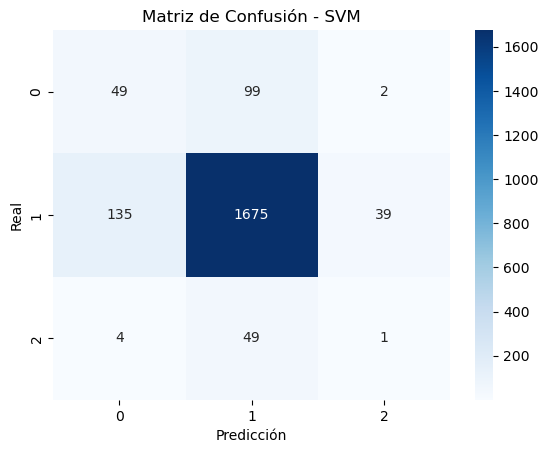

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Escalar los datos
scaler = StandardScaler(with_mean=False)  # Evitar problemas con matrices dispersas
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

# Entrenar el modelo SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train_mapped)

# Predicciones SVM
y_pred_svm = svm_model.predict(X_test_scaled)

# Reporte de clasificación
print("\nReporte de clasificación para SVM:")
print(classification_report(y_test_mapped, y_pred_svm, target_names=['Negativo', 'Neutro', 'Positivo']))

# Matriz de confusión
cm_svm = confusion_matrix(y_test_mapped, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


# RED NEURONAL 


Reporte de clasificación para Red Neuronal:
              precision    recall  f1-score   support

           0       0.11      0.04      0.06        52
           1       0.40      0.21      0.28        47
           2       0.00      0.00      0.00        51
           3       0.20      0.28      0.23       131
           4       0.27      0.26      0.27       389
           5       0.72      0.78      0.75      1329
          10       0.00      0.00      0.00        54

    accuracy                           0.58      2053
   macro avg       0.24      0.23      0.23      2053
weighted avg       0.54      0.58      0.56      2053



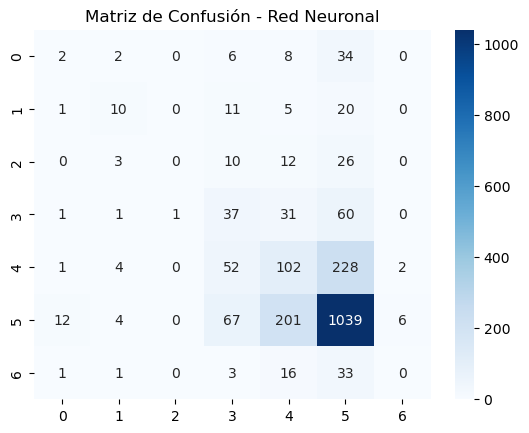

In [15]:

# Red Neuronal
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
mlp_model.fit(X_train_combined, y_train)
y_pred_mlp = mlp_model.predict(X_test_combined)

print("\nReporte de clasificación para Red Neuronal:")
print(classification_report(y_test, y_pred_mlp))

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Red Neuronal')
plt.show()


# COMPARACIÇON MODELOS 

In [ ]:
# convertir string a numero 
# Si tus etiquetas están como strings y quieres convertirlas a números:
label_mapping = {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}
y_test_mapped = y_test.map(label_mapping)

# Aplica el mapeo también para las predicciones:
y_pred_rf_mapped = [label_mapping[label] for label in y_pred_rf]
y_pred_mlp_mapped = [label_mapping[label] for label in y_pred_mlp]
y_pred_svm_mapped = y_pred_svm  # Si ya están mapeadas numéricamente.

print("Etiquetas en y_test:", np.unique(y_test))
print("Etiquetas en y_pred_rf:", np.unique(y_pred_rf))
print("Etiquetas en y_pred_svm:", np.unique(y_pred_svm))
print("Etiquetas en y_pred_mlp:", np.unique(y_pred_mlp))

# Comparación de F1-score promedio
from sklearn.metrics import f1_score
print("\nF1-Score Promedio:")
print(f"Random Forest: {f1_score(y_test_mapped, y_pred_rf_mapped, average='weighted'):.2f}")
print(f"SVM: {f1_score(y_test_mapped, y_pred_svm, average='weighted'):.2f}")
print(f"Red Neuronal: {f1_score(y_test_mapped, y_pred_mlp_mapped, average='weighted'):.2f}")


KeyError: 5

# DETECCION outliers

In [ ]:
# Detección y manejo de outliers usando IQR
q1 = valoraciones['overall'].quantile(0.25)
q3 = valoraciones['overall'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Reemplazar valores fuera del rango IQR por los límites
valoraciones['overall'] = valoraciones['overall'].clip(lower_bound, upper_bound)

# Visualización post-outliers
sns.boxplot(x=valoraciones['overall'])
plt.title('Boxplot de overall después de tratar outliers')
plt.show()


# PCA

In [ ]:
numeric_cols = valoraciones[['review_length']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_cols)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Distribución en las Dos Primeras Componentes Principales')
plt.show()


# Visualizaciones adicionales 

In [ ]:
sns.histplot(valoraciones['overall'], kde=True, bins=20, color='blue')
plt.title('Distribución de Calificaciones con KDE')
plt.show()

valoraciones['reviewTime'] = pd.to_datetime(valoraciones['reviewTime'])
resenas_por_mes = valoraciones.set_index('reviewTime').resample('M').size()
resenas_por_mes.plot()
plt.title('Número de Reseñas por Mes')
plt.show()


# CROSS VALIDATION 

In [ ]:
# Validación cruzada para SVM
scores_svm = cross_val_score(svm_model, X_train_combined, y_train, cv=5, scoring='accuracy')
print(f"Precisión promedio con validación cruzada SVM: {scores_svm.mean():.2f} ± {scores_svm.std():.2f}")

# Validación cruzada para Red Neuronal
scores_mlp = cross_val_score(mlp_model, X_train_combined, y_train, cv=5, scoring='accuracy')
print(f"Precisión promedio con validación cruzada MLP: {scores_mlp.mean():.2f} ± {scores_mlp.std():.2f}")


# Curvas ROC para SVM y Red Neuronal

In [ ]:
# Curvas ROC para SVM y Red Neuronal
for model, name in zip([svm_model, mlp_model], ['SVM', 'MLP']):
    y_score = model.predict_proba(X_test_combined)
    y_test_binarized = label_binarize(y_test, classes=sorted(y.unique()))
    
    for i, class_name in enumerate(['Negativo', 'Neutro', 'Positivo']):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        auc = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{name} - Clase {class_name} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Curvas ROC para {name}')
    plt.legend(loc='lower right')
    plt.show()
